# Embed 'N Classify

"Embed 'N Classify" is an implementation of an Knowledge Graph Embedding (KGE) following up with Classification of the resulting embeddings with different methods. This is an illustration of the pipeline:

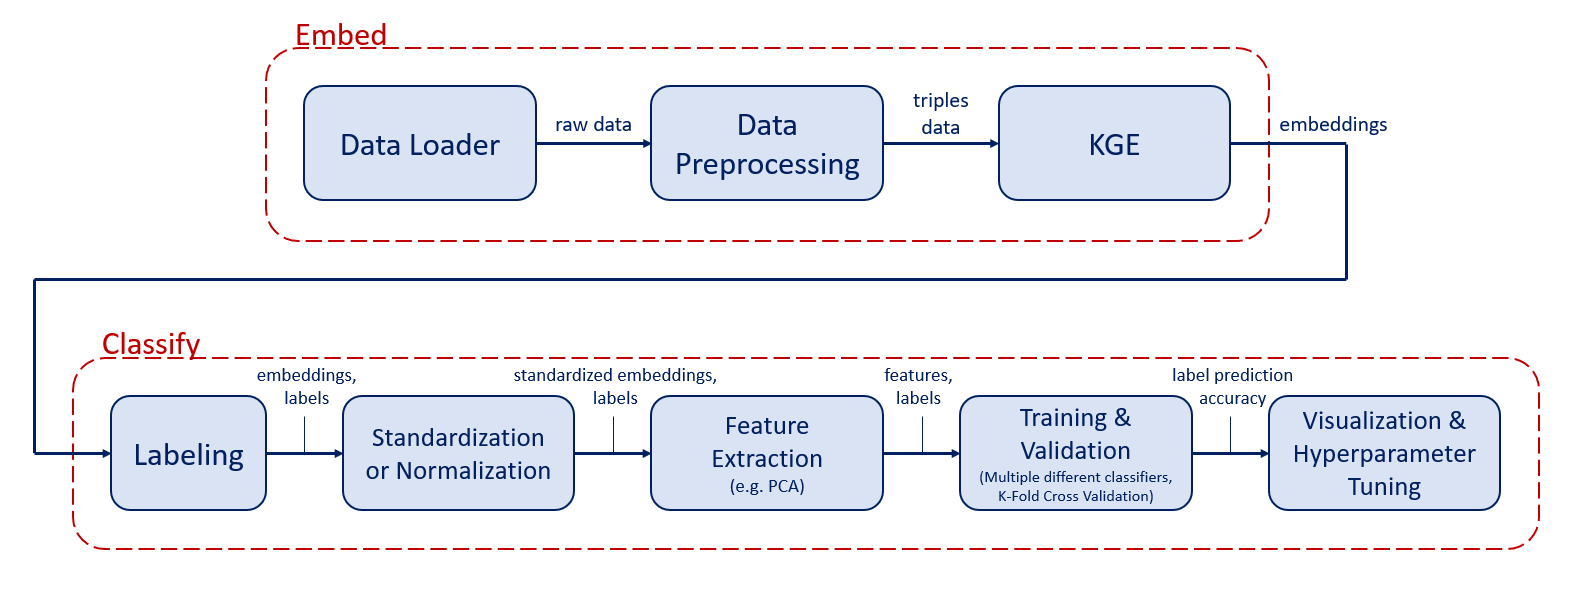

In [1]:
"""Parameters"""

# Choose the dataset, that should be fed into the pipeline:
DATASET_NAME = "Yamanishi"      # "countries_S1" | "Yamanishi" | ...

# Choose the KGE model
MODEL_KGE = "RotatE"            # "TransE" | "RotatE" | "ComplEx" | ...

# Choose dimensionality for embeddings (DIM_KGE) and PCA (DIM_PCA):
DIM_KGE = 50
DIM_PCA = 5

# Choose wether you want to apply PCA on the embeddings
USE_PCA = False

# Labeling:
# Set this parameter to assign labels to embeddings based on a tab-separated
# 'entities-labels.txt' file under the 'data/{DATASET_NAME}/' directory.
USE_LABEL_FILE = True
# Otherwise choose p' and O' for label creation method:
P_DASH = "locatedin"
O_DASH = ["europe", "northern_america"]

# Choose number of folds for K-Fold Cross-Validation
K_FOLD = 5

**Important Instructions**
---

Framework:

Get familiar with the directory structure of the [framework](https://github.com/SHA-T/InteractiveKGE), used in this notebook.
- ***data/***: This directory contains all datasets. You can run the pipeline on any of them. You can add custom datasets under this directory, but keep the structure and format of the files same as the other datasets. Choose the dataset you want to work with by setting the parameter `DATASET_NAME` to the folder name.
- ***models/***: This directory contains the KGE training logs and embeddings as .npy-files in subfolders named ***`DATASET_NAME`_`MODEL_KGE`/***.
- ***embeddings_as_tsv/***: This directory contains the embeddings as .tsv-files in subfolders named ***`DATASET_NAME`_`MODEL_KGE`/***.

---
Embeddings:

If you execute the *Embed* pipeline, embeddings will be saved as .tsv files
under ***embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}/embeddings_with_entity_names.tsv***.

If you want to use already existent embeddings so that you only need to execute the *Classify* pipeline, you need to save those under 

***embeddings_as_tsv/`DATASET_NAME`_`MODEL_KGE`/*** 

and call them 

***embeddings_with_entity_names.tsv***. 

Replace ***`DATASET_NAME`*** and ***`MODEL_KGE`*** by the name of the dataset and the name of the KGE model, on which you trained those embeddings. Also, make sure to set the parameters `DATASET_NAME` and `MODEL_KGE` accordingly in the cell above.

---
Labeling:

You can assign labels by using a tab-separated (TSV) file. The first column contains all entities like in the ***entities.dict*** file. The second column contains the labels. To use this file for labeling you need to set `USE_LABEL_FILE = True`. Currently, a ***entities_labels.txt*** file only exists fot the Yamanishi dataset. If you don't have such a file for your custom dataset, you can create labels using the method defined in the Labeling section. Therefore, you have to set `USE_LABEL_FILE = False` and adjust `P_DASH` and `O_DASH`. Read the instructions under the Labeling section for more information.

In [2]:
# Clone KGE repository
%cd /content/
!rm -r /content/InteractiveKGE
!git clone https://github.com/SHA-T/InteractiveKGE.git
%cd InteractiveKGE

/content
Cloning into 'InteractiveKGE'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 135 (delta 40), reused 120 (delta 28), pack-reused 0
Receiving objects: 100% (135/135), 35.21 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (80/80), done.
/content/InteractiveKGE


In [3]:
# Imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import glob
from PIL import Image
from random import randint
import cv2

## Embed

In [ ]:
# Plotting function
def plot_logs(filename):
  hits1, hits3, hits10, mr, mrr, loss = [], [], [], [], [], []
  keywords = ["Valid HITS@1 ", "Valid HITS@3", "Valid HITS@10", "Valid MR ", "Valid MRR"]
  with open(filename) as f:
      lines = f.readlines()
  read_started = 0
  for line in lines:
    for keyw in keywords:    
      if line.find(keyw) != -1:
        line = line[line.find(keyw):]
        read_started += 1
        value = float(line[line.find(":")+1:].replace("\n", ""))
        if read_started == 1:
          mrr.append(value)
        if read_started == 2:
          mr.append(value)
        if read_started == 3:
          hits1.append(value)
        if read_started == 4:
          hits3.append(value)
        if read_started == 5:
          hits10.append(value)
          read_started = 0
      if line.find("average loss") != -1:
        line = line[line.find("average loss"):]
        value = float(line[line.find(":")+1:].replace("\n", ""))
        loss.append(value)

  fig, ax = plt.subplots(2,3, figsize = (16,8))
  ax[0][0].plot(loss)
  ax[0][0].set_title("Loss")

  ax[0][1].plot(mr)
  ax[0][1].set_title("mr")

  ax[0][2].plot(mrr)
  ax[0][2].set_title("mrr")
  ax[0][2].axis(ymin=0,ymax=1.1)

  ax[1][0].plot(hits1)
  ax[1][0].set_title("hits1")
  ax[1][0].axis(ymin=0,ymax=1.1)

  ax[1][1].plot(hits3)
  ax[1][1].set_title("hits3")
  ax[1][1].axis(ymin=0,ymax=1.1)

  ax[1][2].plot(hits10)
  ax[1][2].set_title("hits10")
  ax[1][2].axis(ymin=0,ymax=1.1)

  return hits1, hits3, hits10, mr, mrr, loss

Train KGE model:

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --cuda \
 --do_valid \
 --do_test \
 --data_path data/{DATASET_NAME} \
 --model {MODEL_KGE} \
 --valid_steps 200 \
 --log_steps 100 \
 -n 64 -b 512 -d {DIM_KGE} \
 -g 0.1 -a 1.0 -adv \
-lr 0.0001 --max_steps 2000 \
-save models/{DATASET_NAME}_{MODEL_KGE} --test_batch_size 8 -de

2023-02-08 23:43:48,076 INFO     Model: RotatE
2023-02-08 23:43:48,077 INFO     Data Path: data/countries_S1
2023-02-08 23:43:48,077 INFO     #entity: 271
2023-02-08 23:43:48,077 INFO     #relation: 2
2023-02-08 23:43:48,078 INFO     #train: 1111
2023-02-08 23:43:48,078 INFO     #valid: 24
2023-02-08 23:43:48,078 INFO     #test: 24
2023-02-08 23:43:48,139 INFO     Model Parameter Configuration:
2023-02-08 23:43:48,139 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2023-02-08 23:43:48,139 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2023-02-08 23:43:48,139 INFO     Parameter entity_embedding: torch.Size([271, 100]), require_grad = True
2023-02-08 23:43:48,139 INFO     Parameter relation_embedding: torch.Size([2, 50]), require_grad = True
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, whi

Plot training:

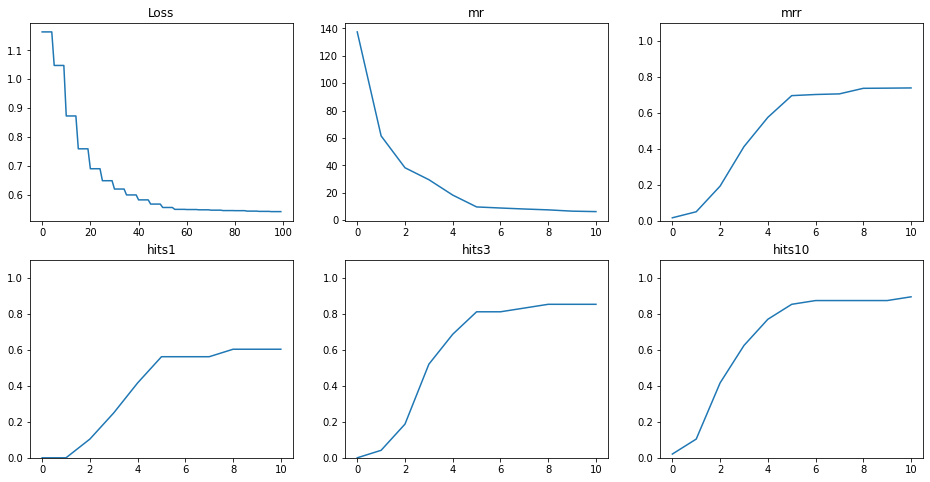

In [ ]:
hits1, hits3, hits10, mr, mrr, loss = plot_logs(f"/content/InteractiveKGE/models/{DATASET_NAME}_{MODEL_KGE}/train.log")

Below cell makes embeddings saveable and displays it

In [ ]:
ent_embeddings = np.load(f"/content/InteractiveKGE/models/{DATASET_NAME}_{MODEL_KGE}/entity_embedding000000.npy")
dim_size = ent_embeddings.shape[1]

headers = []
for x in range(dim_size):
  headers.append("d"+str(x))

ent_names = []
for line in open(f"/content/InteractiveKGE/data/{DATASET_NAME}/entities.dict"):
  ent_names.append(line.split("\t")[1][:-1])

df_ent_embeddings = pd.DataFrame(data=ent_embeddings, index=ent_names, columns=headers)
df_ent_embeddings.sample(5)

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99
new_zealand,0.005200,-0.009226,0.004750,0.026160,-2.711578e-02,0.043222,0.026841,-0.027701,-0.042053,-0.025915,...,-0.009455,0.021444,-0.007762,0.007390,-0.011704,-0.015163,-0.015000,-0.006251,-0.015152,-0.015254
chad,-0.027820,-0.006450,-0.012601,-0.000072,-4.117030e-07,-0.004121,0.000037,-0.004811,0.024118,-0.031242,...,0.000005,-0.022710,0.000002,0.000611,-0.000007,-0.000011,0.000010,0.009528,-0.000003,0.020626
united_kingdom,-0.037535,-0.011141,-0.011006,0.008282,1.546905e-03,0.028340,-0.020226,-0.003481,-0.012514,0.017821,...,-0.020951,-0.004326,0.016873,0.018472,0.007201,0.007564,-0.016610,-0.001385,0.017014,-0.002900
africa,0.030714,-0.007776,0.013805,0.000015,1.320644e-05,0.000869,0.001764,-0.011904,0.022781,-0.013368,...,0.000004,0.021328,0.000004,-0.003557,-0.000005,0.000633,0.008264,-0.004801,-0.000015,-0.023930
lesotho,-0.005898,-0.013200,-0.023785,-0.007348,2.207651e-05,0.004469,0.002863,-0.006284,-0.015077,-0.005966,...,0.000002,-0.022883,-0.000003,-0.016867,-0.006644,-0.009660,0.000017,0.003553,-0.006320,0.029538


Below cell saves the embeddings as TSV

In [ ]:
if not os.path.exists(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}"):
  os.makedirs(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}")

df_ent_embeddings.to_csv(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}/embeddings.tsv", sep="\t",index=False, header=False)
df_ent_embeddings.to_csv(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}/embeddings_with_entity_names.tsv", sep="\t",index=True, header=True)

## Classify
Embedding Classification Pipeline

In [4]:
# Imports

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

### Labeling

If you do not have an ***entities_labels.txt*** file (hence, you did set `USE_LABEL_FILE = False`) we will create the labels from the information given in the triples dataset. For each unique entities we assign a binary label $\in \{0, 1\}$. We assign $1$, if the entity exists as a subject in a triple, where the predicate has the value $p'$ and the object has the value from a given set $O' = \{o_1, ..., o_k\}$, otherwise we assign $0$. This is probably not the best way to create labels, since the embeddings themselves were computed i. a. based on these information. But, we need some way to test this code on multiple datasets.

Example:

$
p' = \text{"locatedin"} \\
O' = \{ \text{"europe"}, \text{"northern_america"} \}
$

The embeddings of all Western Countries (countries located in Europe or Northern-America) will be assigned with the label $1$. All other entities will be assigned with the label $0$.

($p'$ and $O'$ can be set at the beginning of this notebook in the Constants codeblock)

In [5]:
def assign_labels(use_label_file: bool = USE_LABEL_FILE):
  """
  Returns a pandas.Dataframe that contains embeddings and respective labels.
  """
  df = None
  if not use_label_file:
    df = pd.read_csv(f"data/{DATASET_NAME}/train.txt", sep='\t', header=None)

    df = df[(df.iloc[:, 1] == P_DASH) & df.iloc[:, 2].isin(O_DASH)]  # keep rows where predicate = p' & object in O'. Delete the rest

    label_1_entities = df.iloc[:, 0].to_numpy()
    
    # print("Label '1' will be assigned to these entities:\n\n", label_1_entities)

    df = pd.read_csv(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}/embeddings_with_entity_names.tsv", sep='\t')
    df["Y"] = (df.iloc[:, 0].isin(label_1_entities)).astype(int)

  else:
    import csv  # save memory because only needed if here

    # Create a dictionary of structure: {"entity1": "labelA", ...}
    labels_dict = {}
    with open(f"data/{DATASET_NAME}/entities_labels.txt", newline="") as csv_f:
      for row in csv.DictReader(csv_f, fieldnames=["entity", "label"], delimiter='\t'):
        entity = row["entity"]
        labels_dict[entity] = int(row["label"])
    
    # print("labels_dict:\n", labels_dict)

    df = pd.read_csv(f"embeddings_as_tsv/{DATASET_NAME}_{MODEL_KGE}/embeddings_with_entity_names.tsv", sep='\t')
    df["Y"] = df.iloc[:, 0].map(labels_dict)

  return df


df = assign_labels()

Split Dataframe into input X and output y. Then, prepare **K-Fold Cross-Validation**:

In [6]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

cv = KFold(n_splits=K_FOLD, shuffle=True, random_state=0)

### Standardization-Feature Extraction-Classification Pipline

Structure: 
1. **Standardization** of the input features
2. **Feature Extraction** through Dimensionality Reduction with PCA
3. **Classification**

In [7]:
def build_pipeline(classifier, use_pca: bool = USE_PCA):
  """
  Generates and returns a Pipeline.
  """
  if use_pca:
    return Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=DIM_PCA)), 
                     ('classifier', classifier)])
  else:
    return Pipeline([('scaler', StandardScaler()), 
                     ('classifier', classifier)])


# LinearDiscriminantAnalysis Pipeline
LinearDiscriminantAnalysisPipeline = build_pipeline(LinearDiscriminantAnalysis())

# RandomForestClassifier Pipeline
RandomForestClassifierPipeline = build_pipeline(RandomForestClassifier(random_state=0))

# SVC Pipeline
SVCPipeline = build_pipeline(SVC(random_state=0))

# GradientBoostingClassifier Pipeline
GradientBoostingClassifierPipeline = build_pipeline(GradientBoostingClassifier(random_state=0))

# MLPClassifier Pipeline
MLPClassifierPipeline = build_pipeline(MLPClassifier(max_iter=1000, random_state=0))

# ----------------------------------------------------------------------------

# Master Pipeline
master_pipeline = [LinearDiscriminantAnalysisPipeline, RandomForestClassifierPipeline, SVCPipeline, GradientBoostingClassifierPipeline, MLPClassifierPipeline]

# Dictionary for referencing pipeline names
pipeline_dict = {0: "LinearDiscriminantAnalysis", 
                 1: "RandomForestClassifier", 
                 2: "SVC", 
                 3: "GradientBoostingClassifier", 
                 4: "MLPClassifier"}

### Training and Validation

In [8]:
# Training and Testing with K-Fold Cross Validation:
# TODO in future: Multiple loops for seeded models to use more than just 1 seed

avg_scores = []
stds = []

for i, pipe in enumerate(master_pipeline):
  scores = cross_val_score(pipe, X, y, cv=cv)   # K scores of model i
  avg_score = sum(scores) / len(scores)         # avg score of model i
  std = np.std(scores)                          # standard deviation

  avg_scores.append(avg_score)                  # save the average of each model
  stds.append(std)                              # save the st.dev. of each model

  print(f"Cross Validation Scores - {pipeline_dict[i]}: \n{scores} --> Avg: {avg_score} \n")

Cross Validation Scores - LinearDiscriminantAnalysis: 
[0.85393258 0.86235955 0.88202247 0.87359551 0.86797753] --> Avg: 0.8679775280898877 

Cross Validation Scores - RandomForestClassifier: 
[0.85393258 0.87640449 0.90730337 0.85393258 0.86516854] --> Avg: 0.8713483146067416 

Cross Validation Scores - SVC: 
[0.9241573  0.91853933 0.94101124 0.92134831 0.90449438] --> Avg: 0.9219101123595506 

Cross Validation Scores - GradientBoostingClassifier: 
[0.8511236  0.86797753 0.86516854 0.85955056 0.86797753] --> Avg: 0.8623595505617978 

Cross Validation Scores - MLPClassifier: 
[0.88483146 0.88764045 0.91853933 0.91011236 0.91573034] --> Avg: 0.9033707865168539 



### Visualization

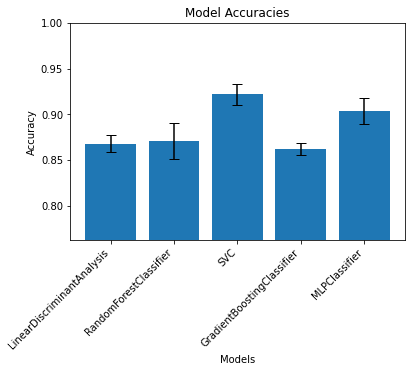

In [9]:
# Plot scores of all models

x_axis = [pipeline_dict[0], pipeline_dict[1], pipeline_dict[2], pipeline_dict[3], pipeline_dict[4]]
y_axis = avg_scores

plt.bar(x_axis, y_axis, yerr=stds, capsize=5)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")

# Set limits of y-axis
ax = plt.gca()
ax.set_ylim([max(min(avg_scores) - 0.1, 0), min(max(avg_scores) + 0.1, 1)])

plt.show()

#### Hyperparameter Tuning

For now we will only tune the hyperparqameters of the MLPClassifier to see if it can improve. We use Grid Search for this.

In [10]:
# Search space for the hyperparameters
hyperparameters = {
    'classifier__max_iter': [1500],
    'classifier__hidden_layer_sizes': [(16,32,16), (64,32), (16,)],
    #'classifier__activation': ['tanh', 'relu'],
    #'classifier__solver': ['sgd', 'adam'],
    #'classifier__alpha': [0.0001, 0.05],
    #'classifier__learning_rate': ['constant','adaptive'],
}

# Perform grid search to find the best hyperparameters
grid = GridSearchCV(MLPClassifierPipeline, hyperparameters, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000,
                                                      random_state=0))]),
             param_grid={'classifier__hidden_layer_sizes': [(16, 32, 16),
                                                            (64, 32), (16,)],
                         'classifier__max_iter': [1500]})

In [11]:
# Update MLPClassifier pipeline in the master_pipeline
master_pipeline[4] = grid.best_estimator_

In [12]:
# Do K-Fold Cross Validation for updated MLPClassifier

scores = cross_val_score(master_pipeline[4], X, y, cv=cv)
avg_score = sum(scores) / len(scores)         # avg score
std = np.std(scores)                          # standard deviation

# If-statement covers the case where this cell is run multiple times
if len(avg_scores) == 5:
  avg_scores.append(avg_score)
  stds.append(std)
else:  # len(avg_scores) == 6
  avg_scores[5] = avg_score
  stds[5] = std

print(f"Cross Validation Scores - {pipeline_dict[4]}: \n{scores} --> Avg: {avg_score} \n")

Cross Validation Scores - MLPClassifier: 
[0.88764045 0.90730337 0.91853933 0.91011236 0.91011236] --> Avg: 0.9067415730337078 



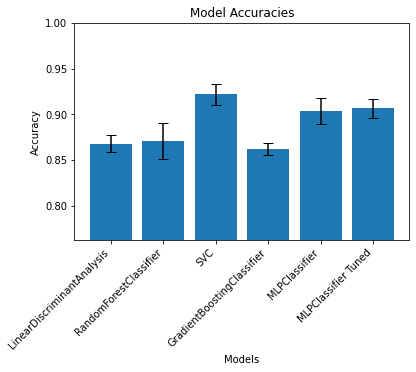

In [13]:
# Re-Plot scores of all models

x_axis = [pipeline_dict[0], pipeline_dict[1], pipeline_dict[2], pipeline_dict[3], pipeline_dict[4], "MLPClassifier Tuned"]
y_axis = avg_scores

plt.bar(x_axis, y_axis, yerr=stds, capsize=5)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")

# Set limits of y-axis
ax = plt.gca()
ax.set_ylim([max(min(avg_scores) - 0.1, 0), min(max(avg_scores) + 0.1, 1)])

plt.show()